Набор данных взят отсюда - https://www.kaggle.com/hb20007/gender-classification

In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [180]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [166]:
df = pd.read_csv("Transformed Data Set - Sheet1.csv")
print(df.shape)
df.head(3)

(66, 5)


,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F


В качестве предикторов (признаков) будем использовать 4 - Favorite Color, Favorite Music Genre, Favorite Beverage и Favorite Soft Drink. все признаки категориальные

Целевая переменная - Gender (цена)

In [167]:
df.columns

Index(['Favorite Color', 'Favorite Music Genre', 'Favorite Beverage',
       'Favorite Soft Drink', 'Gender'],
      dtype='object')

In [168]:
df.loc[df['Gender']== 'F', 'Gender'] = 1
df.loc[df['Gender']== 'M', 'Gender'] = 0
df['Gender']=df['Gender'].astype(int)

In [170]:
df.loc[df['Favorite Color']== 'Cool', 'Favorite Color'] = 0
df.loc[df['Favorite Color']== 'Warm', 'Favorite Color'] = 1
df.loc[df['Favorite Color']== 'Neutral', 'Favorite Color'] = 2
df['Favorite Color']=df['Favorite Color'].astype(int)

In [171]:
df.loc[df['Favorite Music Genre']== 'Rock', 'Favorite Music Genre'] = 0
df.loc[df['Favorite Music Genre']== 'Pop', 'Favorite Music Genre'] = 1
df.loc[df['Favorite Music Genre']== 'Electronic', 'Favorite Music Genre'] = 2
df.loc[df['Favorite Music Genre']== 'Hip hop', 'Favorite Music Genre'] = 3
df.loc[df['Favorite Music Genre']== 'R&B and soul', 'Favorite Music Genre'] = 4
df.loc[df['Favorite Music Genre']== 'Jazz/Blues', 'Favorite Music Genre'] = 5
df.loc[df['Favorite Music Genre']== 'Folk/Traditional', 'Favorite Music Genre'] = 6
df['Favorite Music Genre']=df['Favorite Music Genre'].astype(int)

In [172]:
df.loc[df['Favorite Beverage']== "Doesn't drink", 'Favorite Beverage'] = 0
df.loc[df['Favorite Beverage']== 'Beer', 'Favorite Beverage'] = 1
df.loc[df['Favorite Beverage']== 'Other', 'Favorite Beverage'] = 2
df.loc[df['Favorite Beverage']== 'Wine', 'Favorite Beverage'] = 3
df.loc[df['Favorite Beverage']== 'Vodka', 'Favorite Beverage'] = 4
df.loc[df['Favorite Beverage']== 'Whiskey', 'Favorite Beverage'] = 5

df['Favorite Beverage']=df['Favorite Beverage'].astype(int)

In [173]:
df.loc[df['Favorite Soft Drink']== 'Coca Cola/Pepsi', 'Favorite Soft Drink'] = 0
df.loc[df['Favorite Soft Drink']== 'Fanta', 'Favorite Soft Drink'] = 0
df.loc[df['Favorite Soft Drink']== '7UP/Sprite', 'Favorite Soft Drink'] = 0
df.loc[df['Favorite Soft Drink']== 'Other', 'Favorite Soft Drink'] = 0
df['Favorite Soft Drink']=df['Favorite Soft Drink'].astype(int)

In [174]:
features = ['Favorite Color', 'Favorite Music Genre', 'Favorite Beverage',
       'Favorite Soft Drink']
target = 'Gender'

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=10)

In [181]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)

In [189]:
accuracy_score(y_test, preds)

0.8235294117647058

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


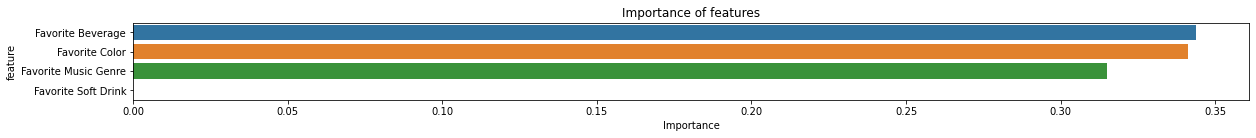

In [186]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=4)

In [191]:
xgb_features = pd.DataFrame(model_xgb.feature_importances_, 
                        features, 
                        columns=['coefficient'])
xgb_features

,coefficient
Favorite Color,0.341146
Favorite Music Genre,0.315027
Favorite Beverage,0.343826
Favorite Soft Drink,0.000000


### 2. Permutation importance

In [193]:
r = permutation_importance(model_xgb, X_test, y_test, n_repeats=30, random_state=0)

In [194]:
for i in r.importances_mean.argsort()[::-1]:
    print(
        f"{features[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Favorite Music Genre 0.310 +/- 0.100
Favorite Beverage 0.206 +/- 0.098
Favorite Color 0.004 +/- 0.066
Favorite Soft Drink 0.000 +/- 0.000


### SHAP

In [197]:
# load JS visualization code to notebook
shap.initjs()

In [210]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [211]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [212]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

In [213]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X_train.iloc[3,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). Признаки, вклад которых сдвигает прогноз "вверх" помечены красным цветом, а другие - синим

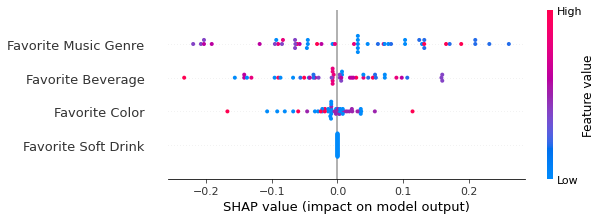

In [214]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- значение признака любимой музыки больше определяет людей мужского пола 
- признак Favorite Soft Drink не влияет на значение

Лучше смотреть такой график при использовании OHE, так как в данный момент не понятно какие именно значения категориальных признаков больше влияют на результат

Можно даже просто взять средние значения SHAP для каждого признака

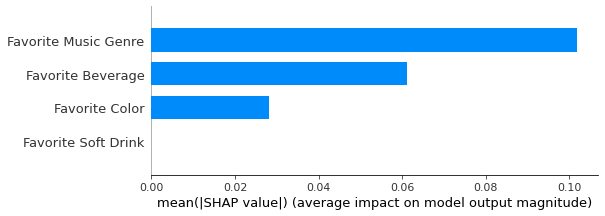

In [200]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [215]:
df= pd.get_dummies(df, prefix='Favorite Color', columns=['Favorite Color'])
df= pd.get_dummies(df, prefix='Favorite Music Genre', columns=['Favorite Music Genre'])
df= pd.get_dummies(df, prefix='Favorite Beverage', columns=['Favorite Beverage'])
df= pd.get_dummies(df, prefix='Favorite Soft Drink', columns=['Favorite Soft Drink'])

In [216]:
df.columns

Index(['Gender', 'Favorite Color_0', 'Favorite Color_1', 'Favorite Color_2',
       'Favorite Music Genre_0', 'Favorite Music Genre_1',
       'Favorite Music Genre_2', 'Favorite Music Genre_3',
       'Favorite Music Genre_4', 'Favorite Music Genre_5',
       'Favorite Music Genre_6', 'Favorite Beverage_0', 'Favorite Beverage_1',
       'Favorite Beverage_2', 'Favorite Beverage_3', 'Favorite Beverage_4',
       'Favorite Beverage_5', 'Favorite Soft Drink_0'],
      dtype='object')

In [217]:
features = ['Favorite Color_0', 'Favorite Color_1', 'Favorite Color_2',
       'Favorite Music Genre_0', 'Favorite Music Genre_1',
       'Favorite Music Genre_2', 'Favorite Music Genre_3',
       'Favorite Music Genre_4', 'Favorite Music Genre_5',
       'Favorite Music Genre_6', 'Favorite Beverage_0', 'Favorite Beverage_1',
       'Favorite Beverage_2', 'Favorite Beverage_3', 'Favorite Beverage_4',
       'Favorite Beverage_5', 'Favorite Soft Drink_0']
target = 'Gender'

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=10)

In [218]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)

In [219]:
accuracy_score(y_test, preds)

0.8235294117647058

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


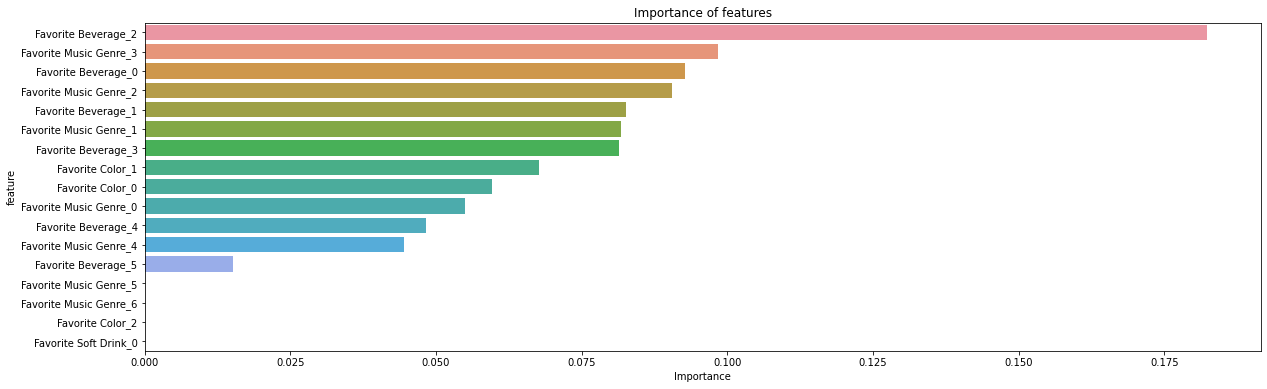

In [221]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=20)

получается, что 4 последних признака вообще не влияют. Favorite Color_2,  Favorite Music Genre_5, Favorite Music Genre_6, Favorite Soft Drink_0	

In [223]:
xgb_features = pd.DataFrame(model_xgb.feature_importances_, 
                        features, 
                        columns=['coefficient'])
xgb_features

,coefficient
Favorite Color_0,0.059581
Favorite Color_1,0.067744
Favorite Color_2,0.000000
Favorite Music Genre_0,0.055047
Favorite Music Genre_1,0.081688
Favorite Music Genre_2,0.090528
Favorite Music Genre_3,0.098359
Favorite Music Genre_4,0.044435
Favorite Music Genre_5,0.000000
Favorite Music Genre_6,0.000000


 Permutation importance

In [224]:
r = permutation_importance(model_xgb, X_test, y_test, n_repeats=30, random_state=0)

In [225]:
for i in r.importances_mean.argsort()[::-1]:
    print(
        f"{features[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Favorite Beverage_1 0.206 +/- 0.091
Favorite Color_1 0.171 +/- 0.061
Favorite Music Genre_1 0.104 +/- 0.045
Favorite Beverage_2 0.080 +/- 0.054
Favorite Music Genre_4 0.055 +/- 0.015
Favorite Music Genre_0 0.039 +/- 0.059
Favorite Music Genre_3 0.033 +/- 0.045
Favorite Color_0 0.006 +/- 0.041
Favorite Beverage_0 0.002 +/- 0.049
Favorite Music Genre_2 0.000 +/- 0.000
Favorite Color_2 0.000 +/- 0.000
Favorite Soft Drink_0 0.000 +/- 0.000
Favorite Music Genre_6 0.000 +/- 0.000
Favorite Beverage_4 0.000 +/- 0.000
Favorite Music Genre_5 0.000 +/- 0.000
Favorite Beverage_5 -0.002 +/- 0.032
Favorite Beverage_3 -0.055 +/- 0.026


к выявленным ранее не существенным признакам Favorite Color_2,  Favorite Music Genre_5, Favorite Music Genre_6, Favorite Soft Drink_0
добавился еще Favorite Beverage_4 0.000 +/- 0.000

SHAP

In [226]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [229]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train.iloc[1,:])

In [230]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_train.iloc[2,:])

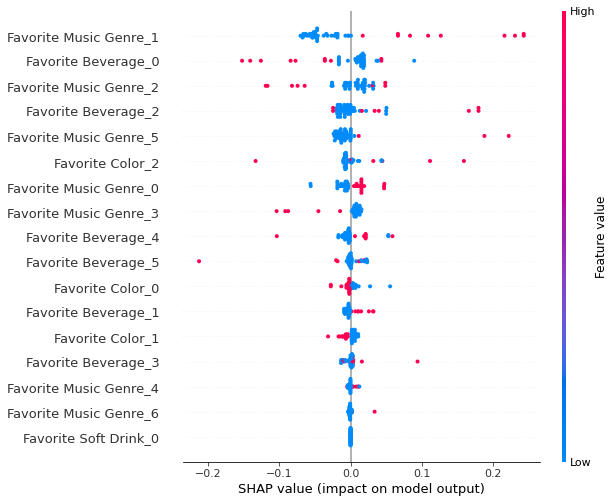

In [227]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [ ]:
Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- Favorite Music Genre_1 равен 0 - то это мужчины
- Favorite Beverage_0 равен 1 - это женщины
- Favorite Music Genre_2 равен 1 - то это женщины
- Favorite Beverage_2 равен 0 - это мужчины и тд

- признак  Favorite Beverage_3, Favorite Music Genre_4, Favorite Music Genre_6, Favorite Soft Drink не влияет 
на значение таргета

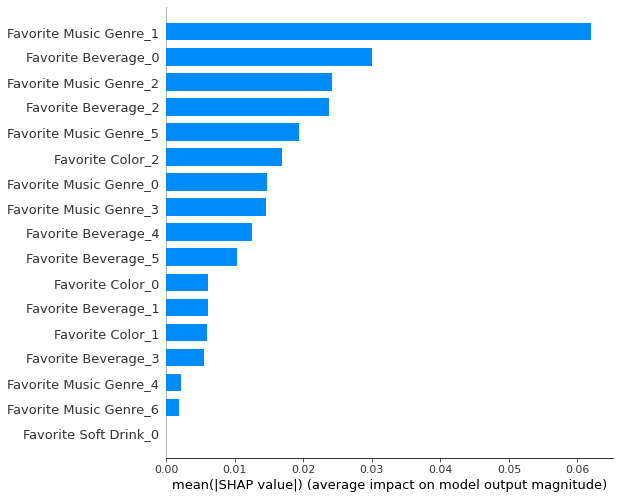

In [228]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value